# Bayesian estimation supersedes the t-test 

André van Schaik<br>
<a href="https://www.westernsydney.edu.au/icns">International Centre for Neuromorphic Systems</a><br>
<a href="https://www.westernsydney.edu.au">Western Sydney University</a><br>
July 2015 - updated March 2023.

This notebook illustrates how to do Bayesian Estimation of the difference between two independent distributions of normally distributed data that may contain outliers. It is based on a paper by <a href="https://jkkweb.sitehost.iu.edu/BEST/">John K. Kruschke: "Bayesian estimation supersedes the t test"</a>.

The Python code used here has been adapted from an <a href="https://github.com/strawlab/best">initial version by Andrew Straw</a>.

To do Markov-Chain Monte Carlo sampling in Python we use <a href="https://www.pymc.io/welcome.html">the PyMC package</a>, which now includes this very <a href="https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/case_studies/BEST.html">example</a>.

In [1]:
%matplotlib inline
import arviz as az
import pymc as pymc
import numpy as np
from bestplot import plot_posterior, plot_data_and_prediction, plot_data
import matplotlib.pyplot as plt

Let's define some data:

In [2]:
# group 1
name1 = 'Group1'
y1 = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
       109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
       96,103,124,101,101,100,101,101,104,100,101])
       
# group 2
name2 = 'Group2'
y2 = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
       104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
       101,100,99,101,100,102,99,100,99])


Now, let's have a look at the two distributions:

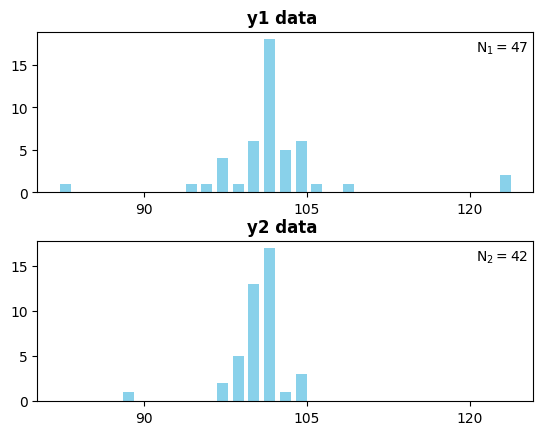

In [3]:
n_bins = 30
y = np.concatenate((y1,y2))
bins = np.linspace(np.min(y),np.max(y),n_bins)
ax = plt.subplot(2,1,1)
plot_data(y1, ax, bins = bins, group = 1, name = 'y1')
ax = plt.subplot(2,1,2)
plot_data(y2, ax, bins = bins, group = 2, name = 'y2')
plt.subplots_adjust(hspace=0.3)

These data distributions look fairly Normal, but they clearly contains outliers. In order to deal with this, we model the data as a t-distribution characterised by a mean, $\mu$, a standard deviation, $\sigma$, and a normality parameter, $\nu$. The normality parameter makes the distribution more Normal if $\nu$ is large (over 30), and gives it bigger tails if $\nu$ gets closer to 1.

Since we do not know what the parameters are for each of the two data distributions, we need to estimate them from the data. To do this in a Bayesian framework, we will need to provide prior distributions that describe our beliefs about these parameters. This leads us to the following hierarchical model:

![](BESThist.jpg)

Here both data distributions (t-distributions) have independent distributions for their means and standard deviations, but share a single normality parameter, assuming outliers are equally likely in both distributions. The distribution for $\mu$ is a normal distribution with a mean equal to the mean of both sets of data, and a standard deviation 1000 times larger than that of the combined data:

In [4]:
y = np.concatenate((y1, y2))        # combine both groups
mu_m = np.mean(y)                   # mean of distribution of group means
mu_p = np.std(y)**2                 # variance of group means

The standard deviation, $\sigma$, of the data is modelled by a uniform distribution where all values between one thousandth of the standard deviation of the data to one thousand times the standard deviation of the data are equally likely. This large range expresses that we are not very certain about the value $\sigma$:

In [5]:
sigma_low = np.std(y)/1000          # lower bound is 1000 times less than std of data
sigma_high = np.std(y)*1000         # upper bound is 1000 times more than std of data

Once these hyperparameters are chosen, we can define our prior distributions for the parameters of our model. These have their usual names in PyMC:

In [6]:
with pymc.Model() as model:
    group1_mean = pymc.Normal('group1_mean', mu_m, mu_p)
    group2_mean = pymc.Normal('group2_mean', mu_m, mu_p)
    group1_std = pymc.Uniform('group1_std', sigma_low, sigma_high)
    group2_std = pymc.Uniform('group2_std', sigma_low, sigma_high)
    nu = pymc.Exponential('nu_minus_one', 1/29) + 1
    
    lam1 = group1_std ** -2
    lam2 = group2_std ** -2

    group1 = pymc.StudentT("group1", nu=nu, mu=group1_mean, lam=lam1, observed=y1)
    group2 = pymc.StudentT("group2", nu=nu, mu=group2_mean, lam=lam2, observed=y2)

Having fully specified our probabilistic model, we can turn our attention to calculating the comparisons of interest in order to evaluate the effect of the drug. To this end, we can specify deterministic nodes in our model for the difference between the group means and the difference between the group standard deviations. Wrapping them in named Deterministic objects signals to PyMC that we wish to record the sampled values as part of the output.

As a joint measure of the groups, we will also estimate the “effect size”, which is the difference in means scaled by the pooled estimates of standard deviation. This quantity can be harder to interpret, since it is no longer in the same units as our data, but the quantity is a function of all four estimated parameters.

In [7]:
with model:
    diff_of_means = pymc.Deterministic("difference of means", group1_mean - group2_mean)
    diff_of_stds = pymc.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pymc.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std ** 2 + group2_std ** 2) / 2))
    log10nu = pymc.Deterministic("log10nu", np.log10(nu))

Now we can sample from the MCMC object using a Markov chain. To learn more about MCMC sampling, I suggest the excellent notebooks on [Probabilistic Programming and Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Prologue/Prologue.ipynb), or my own on [Stochastic Sampling](http://nbviewer.ipython.org/github/vschaik/Stochastic-Sampling/blob/master/Stochastic_Sampling_Notebook.ipynb).

In [8]:
with model:
    trace = pymc.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group1_mean, group2_mean, group1_std, group2_std, nu_minus_one]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


After running this, our estimation is done. We now get the estimated means and standard deviations for both sets of data and compute their differences. We also fix the bins for plotting the histogram to be the same for both sets of data, to show them on the same horizontal axis.

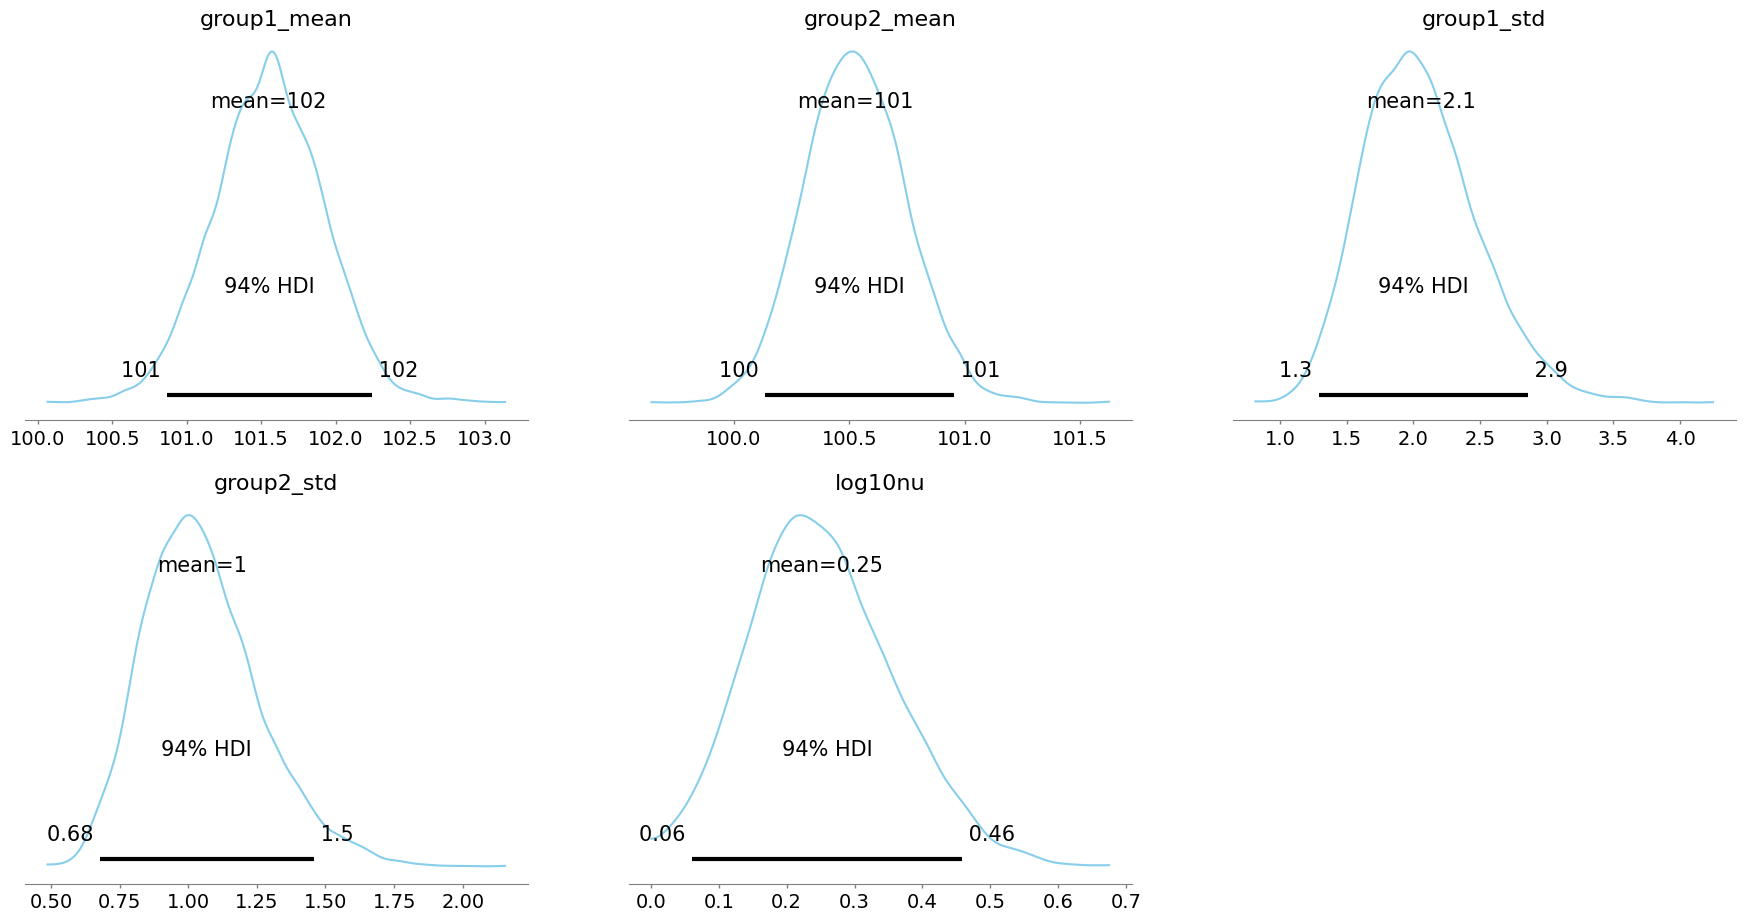

In [9]:
az.plot_posterior(
    trace,
    var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "log10nu"],
    color="#87ceeb",);

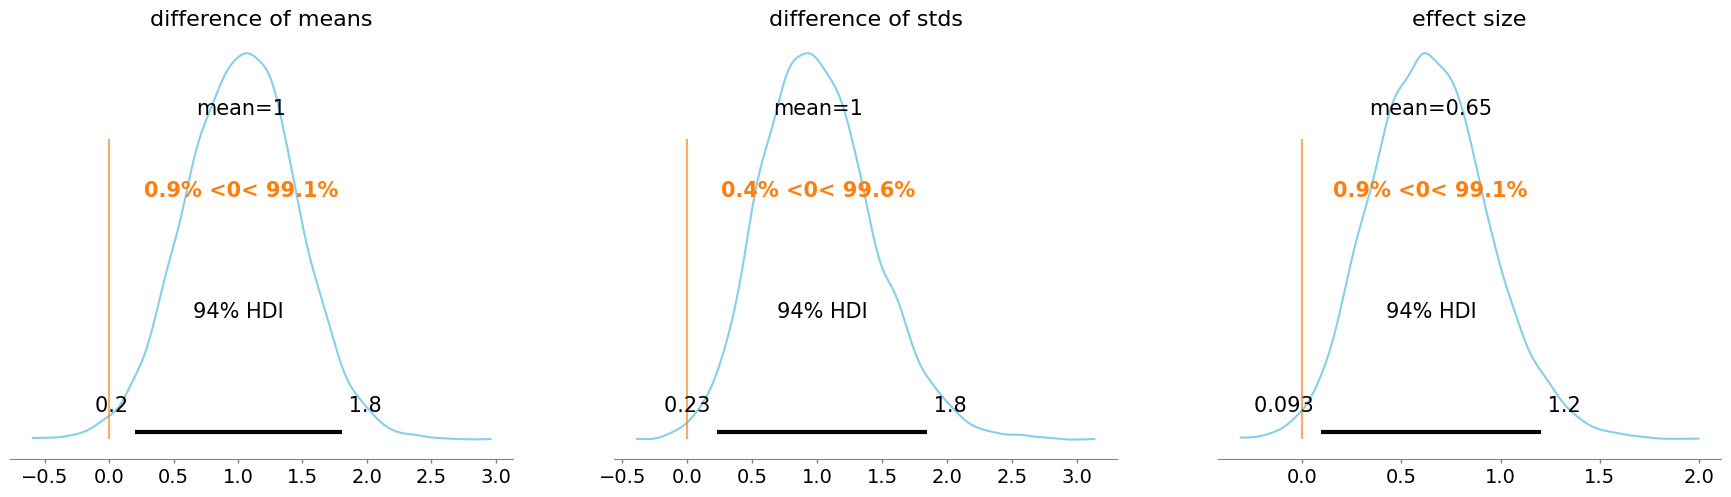

In [10]:
az.plot_posterior(
    trace,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",);

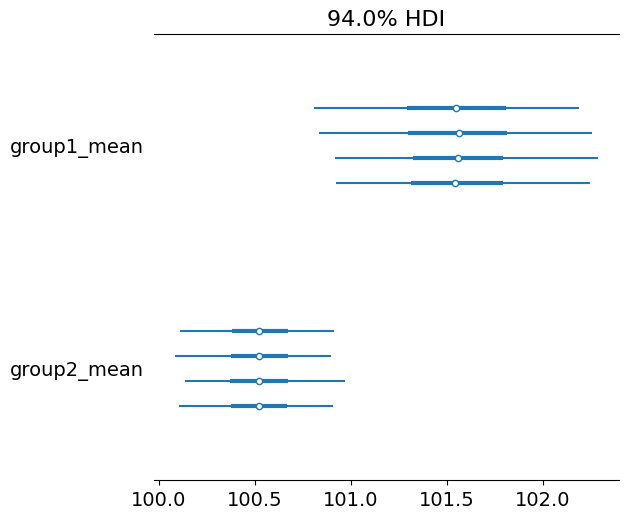

In [11]:
az.plot_forest(trace, var_names=["group1_mean", "group2_mean"]);

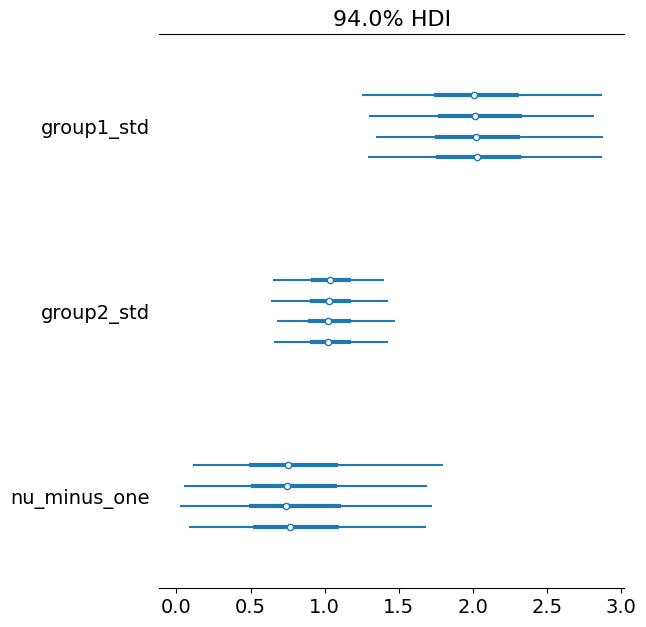

In [12]:
az.plot_forest(trace, var_names=["group1_std", "group2_std", "nu_minus_one"]);

In [13]:
az.summary(trace, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,1.024,0.431,0.203,1.804,0.005,0.004,6951.0,5558.0,1.0
difference of stds,1.007,0.436,0.228,1.846,0.005,0.004,7024.0,6195.0,1.0
effect size,0.647,0.298,0.093,1.206,0.004,0.003,6856.0,5717.0,1.0


The plots above use the ArviZ package as used in the pymc example. The plots we get are different from those in the original paper. My code below attempts to recreate the original plots. This is largely because this is what I did first in 2015 and have now updated to work with the newer version of pymc. Note that the new pymc typically runs multiple traces, but for plotting I'm only using data from trace[0].

In [14]:
# Get the posterior distributions of the means and their difference
posterior_mean1 = trace.get('posterior').group1_mean[0].values
posterior_mean2 = trace.get('posterior').group2_mean[0].values
diff_means = posterior_mean1 - posterior_mean2

# Calculate common bin edges for both posteriors
posterior_means = np.concatenate((posterior_mean1, posterior_mean2))
bin_edges_means = np.linspace( np.min(posterior_means), np.max(posterior_means), n_bins )

In [15]:
# Get the posteriaor distributions of the std and their difference
posterior_std1 = trace.get('posterior').group1_std[0].values
posterior_std2 = trace.get('posterior').group2_std[0].values
diff_stds = posterior_std1 - posterior_std2

# Calculate common bin edges for both posteriors
posterior_stds = np.concatenate((posterior_std1, posterior_std2))
bin_edges_stds = np.linspace(np.min(posterior_stds), np.max(posterior_stds), n_bins)

We also calculate the effect size for the difference of the means, and convert the $\nu$ parameter to a log scale:

In [16]:
# Calculate effect size
effect_size = diff_means/np.sqrt((posterior_std1**2 + posterior_std2**2)/2)

In [17]:
# Get the distribution of the normality parameter
post_nu_minus_one = trace.get('posterior').nu_minus_one[0].values
# and convert to log10 scale
lognu = np.log10(post_nu_minus_one + 1)

Finally we define 10 subplots that we plot using the routines provided in the bestplot.py file.

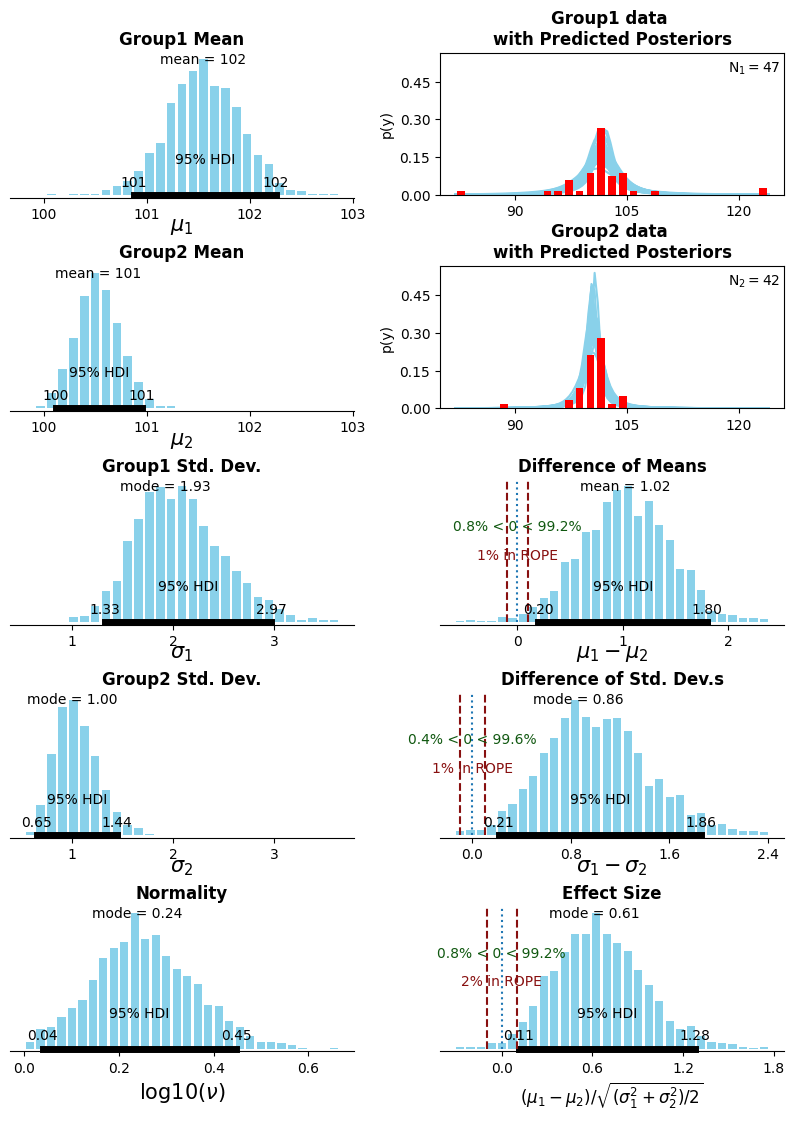

In [18]:
# Create a figure to hold 5 rows and 2 columns
f = plt.figure(figsize = (9,12), facecolor = 'white')

# Left column, top two: plot the distribution of the means
ax1 = f.add_subplot(5, 2, 1, facecolor = 'none')
plot_posterior( posterior_mean1, 
                ax = ax1, 
                bins = bin_edges_means, 
                title = name1 + ' Mean', 
                label = r'$\mu_1$',
                ctd = 'mean',
                printstats = False
              )

ax3 = f.add_subplot(5, 2, 3, facecolor = 'none')
plot_posterior( posterior_mean2, 
                ax = ax3, 
                bins = bin_edges_means,
                title = name2 + ' Mean', 
                label = r'$\mu_2$', 
                ctd = 'mean', 
                printstats = False
              )

# Left column, next two: plot the distribution of the stds
ax5 = f.add_subplot(5, 2, 5, facecolor = 'none')
plot_posterior( posterior_std1, 
                ax = ax5, 
                bins = bin_edges_stds,
                title = name1 + ' Std. Dev.', 
                label = r'$\sigma_1$', 
                ctd = 'mode', 
                printstats = False
              )

ax7 = f.add_subplot(5, 2, 7, facecolor = 'none')
plot_posterior( posterior_std2, 
                ax = ax7, 
                bins = bin_edges_stds,
                title = name2 + ' Std. Dev.',
                label = r'$\sigma_2$', 
                ctd = 'mode', 
                printstats = False
              )

# Left column, bottom row: Plot log10(nu)
ax9 = f.add_subplot(5, 2, 9, facecolor = 'none')
plot_posterior( lognu, 
                ax = ax9, 
                bins = n_bins,
                title = 'Normality',
                label = r'$\mathrm{log10}(\nu)$', 
                ctd = 'mode', 
                printstats = False
              )

#Right column, top two: plot histogram of data and 50 of the t-distribution fits from the MCMC chain
bin_edges = np.linspace( np.min(y), np.max(y), n_bins )
ax2 = f.add_subplot(5, 2, 2, facecolor = 'none')
plot_data_and_prediction( y1, 
                          posterior_mean1, 
                          posterior_std1,
                          post_nu_minus_one, 
                          ax2, 
                          bins = bin_edges, 
                          group = 1, 
                          name = name1, 
                        )

ax4 = f.add_subplot(5, 2, 4, facecolor = 'none', sharex = ax2, sharey = ax2)
plot_data_and_prediction( y2, 
                          posterior_mean2, 
                          posterior_std2,
                          post_nu_minus_one, 
                          ax4, 
                          bins = bin_edges, 
                          group = 2, 
                          name = name2, 
                        )

# Right column, third panel: plot the distribution of the differences of the means.
ax6 = f.add_subplot(5, 2, 6, facecolor = 'none')
plot_posterior( diff_means, 
                ax = ax6, 
                bins = n_bins,
                title = 'Difference of Means',
                label = r'$\mu_1 - \mu_2$',
                ctd = 'mean', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-0.1, 0.1], 
                printstats = False
              )

# Right column, fourth panel: plot the distribution of the differences of the stds.
ax8 = f.add_subplot(5, 2, 8, facecolor = 'none')
plot_posterior( diff_stds, 
                ax = ax8, 
                bins = n_bins,
                title = 'Difference of Std. Dev.s',
                label = r'$\sigma_1 - \sigma_2$',
                ctd = 'mode', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-0.1, 0.1], 
                printstats = False
              )

# Right column, bottom panel: plot the effect size
ax10 = f.add_subplot(5, 2, 10, facecolor = 'none')
plot_posterior( effect_size, 
                ax = ax10, 
                bins = n_bins,
                title = 'Effect Size',
                label = r'$(\mu_1 - \mu_2)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$',
                ctd = 'mode', 
                draw_zero = True,
                compVal = 0.0,
                ROPE = [-0.1, 0.1], 
                printstats = False
              )

f.subplots_adjust(hspace = 0.5, top = 0.92, bottom = 0.09,
                  left = 0.09, right = 0.95, wspace = 0.25)


I have also created [an iPython notebook on how to deal with two paired datasets](./BEST-Paired.ipynb).